## imports

In [1]:
import os
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

# to track progress
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

In [3]:
# download file

if not os.path.exists("V_228.csv"):
    url = "https://cloud.dfki.de/owncloud/index.php/s/G5n9EXTbAjk653J/download"
    r = requests.get(url, allow_redirects=True)
    open("V_228.csv", 'wb').write(r.content)
    print("file downloaded")
else:
    print("file already exists")

file downloaded


In [4]:
df = pd.read_csv("V_228.csv", header=None).T    # read csv
df = df[:2]           # get only 2 cols
data = np.array(df)   # conver to np array  

# split data to train, val and test
test = data[:,-1440:]
val = data[:,-2880:-1440]
train = data[:,:-2880]

print(train.shape)
print(val.shape)
print(test.shape)

(2, 9792)
(2, 1440)
(2, 1440)


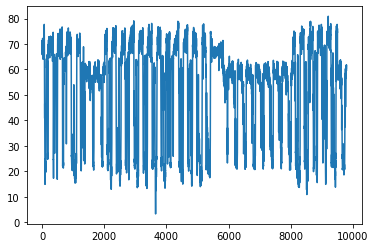

In [5]:
plt.plot(np.transpose(train[0]))    # visualize a sample

In [6]:
def toPatches(data, window_size, horizon, stride):

  n_samples, n_timesteps = data.shape
  n_patches = int(np.floor((n_timesteps-window_size)/stride + 1))
  n_patches -= horizon    # subtract horizon otherwise last patch wont have output
  
  in_patches = []
  out_patches = []
  for sample in data:
    for i in range(0,n_patches,stride):

      start = i
      end = i + window_size

      in_patches.append(sample[start : end])
      out_patches.append(sample[end : end+horizon])

  return np.array(in_patches), np.array(out_patches)

In [7]:
train_in, train_out = toPatches(train, window_size=12, horizon=9, stride=1)
val_in, val_out = toPatches(val, window_size=12, horizon=9, stride=1)
test_in, test_out = toPatches(test, window_size=12, horizon=9, stride=1)

print(train_in.shape)
print(val_in.shape)
print(test_in.shape)

(19544, 12)
(2840, 12)
(2840, 12)


## create dataloader

In [8]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inp, out):
    self.inp = inp
    self.out = out

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, index):
    input = self.inp[index]
    label = self.out[index]
    return input,label


train_dataset = mydataset(train_in, train_out)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## Approaches

define function to train the model

In [9]:
def trainNet(net,criterion,optimizer,train_loader,val_loader,epochs,check_every=None,earlyStopping=False, approach="MLP"):

  print("training network")

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  avg_trainLosses = []
  avg_valLosses = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,outTrueBatch) in enumerate(train_loader):

        inputBatch = inputBatch.to(device).float()
        if approach == "CNN":
          inputBatch = inputBatch.unsqueeze(0).transpose(0,1)
        elif approach == "LSTM":
          inputBatch = inputBatch.unsqueeze(0).permute(1,2,0)

        outTrueBatch = outTrueBatch.to(device).float()

        # zero the parameter gradients
        optimizer.zero_grad()
        if approach == "LSTM":
          net.hidden = net.init_hidden(inputBatch.shape[0])# detaching it from its history on the last instance.

        # forward
        outPredBatch = net(inputBatch)
        loss = criterion(outPredBatch, outTrueBatch)
        train_loss.append(loss.item())

        # backward + optimize
        loss.backward()
        optimizer.step()

    net.eval()
    for i, (inputBatch,outTrueBatch) in enumerate(val_loader):
      with torch.no_grad():

        inputBatch = inputBatch.to(device).float()
        if approach == "CNN":
          inputBatch = inputBatch.unsqueeze(0).transpose(0,1)
        elif approach == "LSTM":
          inputBatch = inputBatch.unsqueeze(0).permute(1,2,0)

        outTrueBatch = outTrueBatch.to(device).float()

        if approach == "LSTM":
          net.hidden = net.init_hidden(inputBatch.shape[0])# detaching it from its history on the last instance.

        # forward
        outPredBatch = net(inputBatch)
        loss = criterion(outPredBatch, outTrueBatch)
        val_loss.append(loss.item())

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)
    avg_trainLosses.append(avg_trainLoss)

    if epoch > 0:
      if avg_valLoss < min(avg_valLosses):
        best_params = copy.deepcopy(net.state_dict())
        best_epoch, best_loss = epoch, avg_valLoss
    else:
      movAvg_old = avg_valLoss    
    avg_valLosses.append(avg_valLoss)   

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d  | train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss), end="  | ")
      movAvg_new = np.mean(avg_valLosses[epoch+1-check_every:epoch+1])
      print('avg train loss: %.3f, avg val loss: %.3f' % (np.mean(avg_trainLosses[epoch+1-check_every:epoch+1]), movAvg_new))

      if earlyStopping:
        if movAvg_old < movAvg_new:
          break
        else:
          movAvg_old = movAvg_new



  print('Finished Training')
  plt.plot(avg_trainLosses, label='train loss')
  plt.plot(avg_valLosses, label='val loss')
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params

define function to evluate the model

In [10]:
def evaluate(net, loader, approach="MLP"):
  net.eval()
  error = 0
  for i, (inputBatch,outTrueBatch) in enumerate(loader):
    with torch.no_grad():

      inputBatch = inputBatch.to(device).float()
      if approach == "CNN":
        inputBatch = inputBatch.unsqueeze(0).transpose(0,1)
      elif approach == "LSTM":
        inputBatch = inputBatch.unsqueeze(0).permute(1,2,0)

      outTrueBatch = outTrueBatch.to(device).float()

      if approach == "LSTM":
          net.hidden = net.init_hidden(inputBatch.shape[0])# detaching it from its history on the last instance.

      # forward
      outPredBatch = net(inputBatch)

      for outTrue, outPred in zip(outTrueBatch,outPredBatch):
        error += (outTrue - outPred)**2

  error = (error/(len(loader.dataset)))**0.5
  print("rmse:",error)
  print("avg rmse:",torch.mean(error))

### MLP

#### define the network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 9)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### create network

In [12]:
model = Net().to(device)
print("params:",count_parameters(model))

#Define a Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

params: 1137


#### train

training network


epoch: 5  | train loss: 77.347, val loss: 77.541  | avg train loss: 165.090, avg val loss: 78.649
epoch: 10  | train loss: 73.894, val loss: 71.734  | avg train loss: 75.268, avg val loss: 73.445
epoch: 15  | train loss: 73.255, val loss: 70.586  | avg train loss: 73.465, avg val loss: 71.344
epoch: 20  | train loss: 72.826, val loss: 70.495  | avg train loss: 72.923, avg val loss: 71.371
epoch: 25  | train loss: 72.121, val loss: 73.975  | avg train loss: 72.469, avg val loss: 71.267
epoch: 30  | train loss: 71.343, val loss: 70.431  | avg train loss: 71.597, avg val loss: 69.971
epoch: 35  | train loss: 70.862, val loss: 69.326  | avg train loss: 71.024, avg val loss: 69.080
epoch: 40  | train loss: 70.374, val loss: 69.616  | avg train loss: 70.579, avg val loss: 69.674
epoch: 45  | train loss: 69.924, val loss: 67.405  | avg train loss: 70.173, avg val loss: 68.710
epoch: 50  | train loss: 69.610, val loss: 68.607  | avg train loss: 69.589, avg val loss: 69.171

Finished Training


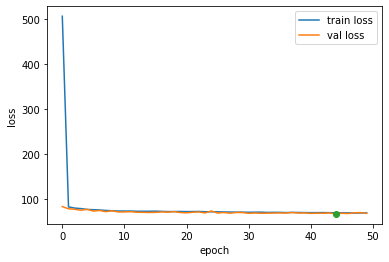

In [13]:
best_params = trainNet(model, criterion, optimizer, train_loader, val_loader, epochs=50, approach="MLP")

In [14]:
model.load_state_dict(best_params)

<All keys matched successfully>

#### evaluate

In [15]:
evaluate(model,test_loader, approach="MLP")

rmse: tensor([ 3.1571,  5.0647,  6.6221,  7.9773,  9.0874, 10.0223, 10.7927, 11.4410,
        11.9810])
avg rmse: tensor(8.4606)


### CNN

#### define the network

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input channels, 8 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(1, 4, 3)
        self.conv2 = nn.Conv1d(4, 8, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### create network

In [17]:
model = Net().to(device)
print("params:",count_parameters(model))

#Define a Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

params: 705


#### train

training network


epoch: 5  | train loss: 88.967, val loss: 84.629  | avg train loss: 165.794, avg val loss: 106.198
epoch: 10  | train loss: 78.753, val loss: 76.219  | avg train loss: 81.346, avg val loss: 78.775
epoch: 15  | train loss: 76.023, val loss: 73.924  | avg train loss: 76.852, avg val loss: 75.069
epoch: 20  | train loss: 74.296, val loss: 72.952  | avg train loss: 74.973, avg val loss: 73.222
epoch: 25  | train loss: 73.567, val loss: 73.047  | avg train loss: 73.921, avg val loss: 72.305
epoch: 30  | train loss: 73.229, val loss: 70.977  | avg train loss: 73.244, avg val loss: 71.405
epoch: 35  | train loss: 72.551, val loss: 71.290  | avg train loss: 72.734, avg val loss: 71.511
epoch: 40  | train loss: 72.251, val loss: 70.864  | avg train loss: 72.234, avg val loss: 71.427
epoch: 45  | train loss: 71.757, val loss: 70.958  | avg train loss: 71.975, avg val loss: 70.404
epoch: 50  | train loss: 71.747, val loss: 69.867  | avg train loss: 71.827, avg val loss: 70.922

Finished Training


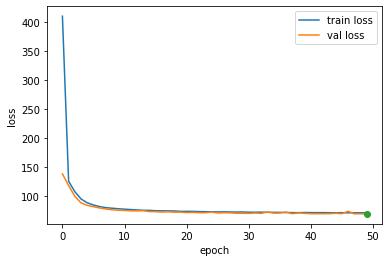

In [18]:
best_params = trainNet(model, criterion, optimizer, train_loader, val_loader, epochs=50, approach="CNN")

In [19]:
model.load_state_dict(best_params)

<All keys matched successfully>

#### evaluate

In [20]:
evaluate(model,test_loader, approach="CNN")

rmse: tensor([ 3.1888,  5.0678,  6.6501,  7.9935,  9.1333, 10.0895, 10.8789, 11.5592,
        12.1477])
avg rmse: tensor(8.5232)


### LSTM

#### define the network

In [21]:
class MV_LSTM(torch.nn.Module):
  def __init__(self,n_features,seq_length):
    super(MV_LSTM, self).__init__()
    self.n_features = n_features
    self.seq_len = seq_length
    self.n_hidden = 5 # number of hidden states
    self.n_layers = 2 # number of LSTM layers (stacked)

    self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                              hidden_size = self.n_hidden,
                              num_layers = self.n_layers, 
                              batch_first = True)
    # according to pytorch docs LSTM output is 
    # (batch_size,seq_len, num_directions * hidden_size)
    # when considering batch_first = True
    self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 9)
      
  
  def init_hidden(self, batch_size):
    # even with batch_first = True this remains same as docs
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    self.hidden = (hidden_state, cell_state)
  
  
  def forward(self, x):        
    batch_size, seq_len, _ = x.size()
    
    lstm_out, self.hidden = self.l_lstm(x,self.hidden)
    # lstm_out(with batch_first = True) is 
    # (batch_size,seq_len,num_directions * hidden_size)
    # for following linear layer we want to keep batch_size dimension and merge rest       
    # .contiguous() -> solves tensor compatibility error
    x = lstm_out.contiguous().view(batch_size,-1)
    return self.l_linear(x)

#### create network

In [22]:
# create NN
model = MV_LSTM(n_features=1,seq_length=12).to(device)
print(count_parameters(model))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

949


#### train

training network


epoch: 5  | train loss: 114.846, val loss: 113.486  | avg train loss: 691.032, avg val loss: 410.402
epoch: 10  | train loss: 83.710, val loss: 79.702  | avg train loss: 90.355, avg val loss: 87.750
epoch: 15  | train loss: 75.057, val loss: 76.630  | avg train loss: 78.441, avg val loss: 77.990
epoch: 20  | train loss: 70.018, val loss: 66.283  | avg train loss: 72.008, avg val loss: 69.341
epoch: 25  | train loss: 68.096, val loss: 65.749  | avg train loss: 68.690, avg val loss: 67.334
epoch: 30  | train loss: 66.853, val loss: 64.997  | avg train loss: 67.188, avg val loss: 65.515
epoch: 35  | train loss: 66.008, val loss: 63.150  | avg train loss: 66.306, avg val loss: 63.657
epoch: 40  | train loss: 65.693, val loss: 61.424  | avg train loss: 65.811, avg val loss: 65.104
epoch: 45  | train loss: 65.336, val loss: 62.274  | avg train loss: 65.319, avg val loss: 63.518
epoch: 50  | train loss: 64.714, val loss: 62.110  | avg train loss: 65.046, avg val loss: 63.244

Finished Trainin

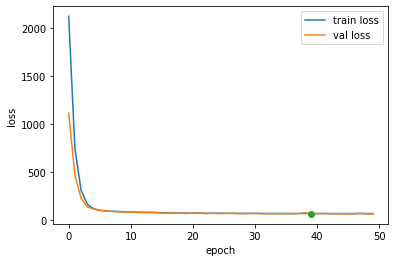

In [23]:
best_params = trainNet(model, criterion, optimizer, train_loader, val_loader, epochs=50, check_every=5, approach="LSTM")

In [24]:
model.load_state_dict(best_params)

<All keys matched successfully>

#### evaluate

In [25]:
evaluate(model,test_loader, approach="LSTM")

rmse: tensor([ 3.8040,  5.2959,  6.6212,  7.7684,  8.7411,  9.5704, 10.2733, 10.8825,
        11.4115])
avg rmse: tensor(8.2632)
